#### Họ và tên: Trần Trung Hiếu
#### MSSV: 1712442

In [143]:
!pip install plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import plotly.express as px
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

%matplotlib inline
plt.style.use('seaborn-pastel')

Defaulting to user installation because normal site-packages is not writeable


## Giới thiệu dữ liệu

Dữ liệu <i>FIFA 19 complete player dataset</i> được lấy từ Kaggle tại [đây](https://www.kaggle.com/karangadiya/fifa19).

Đây là dữ liệu chứa thông tin về các cầu thủ của FIFA vào năm 2019 của [SoFIFA](https://sofifa.com/). Dữ liệu được tác giả thu thập bằng thư viện BeautifulSoup và requests trong Python.

Theo thông tin về license mà tác giả đưa ra trên Kaggle, CC BY-NC-SA 4.0 cho phép người sử dụng chia sẻ và tùy chỉnh dữ liệu.


In [2]:
# Đọc file csv
football_df = pd.read_csv('data.csv', index_col=[0])

## Khám phá dữ liệu

In [3]:
football_df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [4]:
print("Number of rows: %d\nNumber of columns: %d" % (football_df.shape))

Number of rows: 18207
Number of columns: 88


In [5]:
# Liệt kê các cột ứng với kiểu dữ liệu và số lượng dòng khác rỗng
football_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18207 entries, 0 to 18206
Data columns (total 88 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        18207 non-null  int64  
 1   Name                      18207 non-null  object 
 2   Age                       18207 non-null  int64  
 3   Photo                     18207 non-null  object 
 4   Nationality               18207 non-null  object 
 5   Flag                      18207 non-null  object 
 6   Overall                   18207 non-null  int64  
 7   Potential                 18207 non-null  int64  
 8   Club                      17966 non-null  object 
 9   Club Logo                 18207 non-null  object 
 10  Value                     18207 non-null  object 
 11  Wage                      18207 non-null  object 
 12  Special                   18207 non-null  int64  
 13  Preferred Foot            18159 non-null  object 
 14  Intern

In [6]:
# Đếm các giá trị null
football_df.isnull().sum()

ID                   0
Name                 0
Age                  0
Photo                0
Nationality          0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 88, dtype: int64

## Tiền xử lí dữ liệu

#### Loại bỏ các cột không cần thiết

Đầu tiên cần loại bỏ bớt các cột không cần thiết trong bài phân tích này dựa trên những cột được liệt kê phía trên.

Như quan sát, những cột như Joined, Loaned From, Contract Valid Until, Release Clause và cùng với LS, ST, RS, LW, LF, CF, RF, RW, LAM, CAM, RAM, LM, LCM, CM, RCM, RM, LWB, LDM, CDM, RDM, RWB, LB, LCB, CB, RCB, RB là những cột có giá trị thiếu rất nhiều, và những cột này cũng không cần thiết trong quá trình phân tích cho nên ta sẽ loại bỏ nó và đồng thời cũng loại bỏ một số cột không cần thiết khác.

Dưới đây là mô tả về các cột được sử dụng trong phân tích của dữ liệu FIFA 19 complete player:

+ ID: chỉ số định danh trên FIFA

+ Name: tên cầu thủ.

+ Age: tuổi cầu thủ.

+ Nationality: quốc tịch cầu thủ.

+ Club: câu lạc bộ đang thi đấu.

+ Value: giá trị chuyển nhượng.

+ Wage: lương của cầu thủ.

+ Overall: đánh giá tổng quan.

+ Potential: tiềm năng.

+ Preferred Foot: chân thuận.

+ Position: vị trí trong sân.

+ Height/Weight: chiều cao và cân nặng của cầu thủ.

+ Crossing, Finishing, HeadingAccuracy, ShortPassing, Volleys: các chỉ số về tấn công.

+ Dribbling, Curve, FKAccuracy, LongPassing, BallControl: các chỉ số về kĩ năng.

+ Acceleration, SprintSpeed, Agility, Reactions, Balance: các chỉ số về di chuyển.

+ ShotPower, Jumping, Stamina, Strength, LongShots: các chỉ số về sức mạnh.

+ Aggression, Interceptions, Positioning, Vision, Penalties, Composure: các chỉ số về tinh thần.

+ Marking, StandingTackle, SlidingTackle : các chỉ số về phòng thủ.

+ GKKicking, GKPositioning, GKReflexes, GKDiving, GKHandling: các chỉ số về giữ lưới thủ môn.

In [7]:
football_df = football_df[[
    'ID', 'Name', 'Age', 'Nationality', 'Club', 'Value', 'Wage', 'Overall', 'Potential', 
    'Preferred Foot', 'Position', 'Height', 'Weight', 
    'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
    'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
    'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 
    'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
    'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
    'Marking', 'StandingTackle', 'SlidingTackle',
    'GKKicking', 'GKPositioning', 'GKReflexes', 'GKDiving', 'GKHandling'
]]

In [8]:
print("Number of rows: %d\nNumber of columns: %d" % (football_df.shape))

Number of rows: 18207
Number of columns: 47


#### Xử lí các giá trị bị thiếu

Đối với những dòng có Club là NaN, có thể là những cầu thủ này chưa có câu lạc bộ cho nên ta sẽ điền 'No Club' vào.

In [9]:
football_df['Club'].fillna('No Club', inplace=True)

Liệt kê các dòng còn giá trị thiếu để xem xét xử lí.

In [10]:
football_df[football_df.isnull().any(axis=1)]

,ID,Name,Age,Nationality,Club,Value,Wage,Overall,Potential,Preferred Foot,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKKicking,GKPositioning,GKReflexes,GKDiving,GKHandling
5018,153160,R. Raldes,37,Bolivia,No Club,€0,€0,70,70,Right,...,77.0,64.0,79.0,70.0,70.0,11.0,12.0,13.0,16.0,8.0
6736,175393,J. Arce,33,Bolivia,No Club,€0,€0,68,68,Left,...,69.0,67.0,12.0,34.0,33.0,15.0,16.0,8.0,16.0,13.0
7922,195905,L. Gutiérrez,33,Bolivia,No Club,€0,€0,67,67,Right,...,42.0,54.0,72.0,71.0,64.0,8.0,12.0,12.0,11.0,7.0
9905,226044,R. Vargas,23,Bolivia,No Club,€0,€0,66,69,Right,...,67.0,64.0,19.0,24.0,23.0,11.0,7.0,9.0,13.0,11.0
10628,216751,D. Bejarano,26,Bolivia,No Club,€0,€0,65,66,Right,...,39.0,57.0,68.0,69.0,68.0,11.0,14.0,12.0,14.0,12.0
13236,177971,J. McNulty,33,Scotland,Rochdale,€120K,€1K,62,62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13237,195380,J. Barrera,29,Nicaragua,Boyacá Chicó FC,€300K,€1K,62,62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13238,139317,J. Stead,35,England,Notts County,€140K,€3K,62,62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13239,240437,A. Semprini,20,Italy,Brescia,€425K,€1K,62,72,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13240,209462,R. Bingham,24,England,Hamilton Academical FC,€400K,€1K,62,66,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Theo quan sát, một số các cầu thủ có nhiều cột chỉ số bị thiếu, cho nên ta sẽ thực hiện loại bỏ các cầu thủ đó và chỉ giữ lại các cầu thủ có ít nhất 11 cột không bị thiếu giá trị, đây là những cột chứa thông tin cá nhân của cầu thủ.

In [11]:
football_df.dropna(thresh=11, inplace=True)

In [12]:
# Đếm các giá trị null
football_df.isnull().sum()

ID                  0
Name                0
Age                 0
Nationality         0
Club                0
Value               0
Wage                0
Overall             0
Potential           0
Preferred Foot      0
Position           12
Height              0
Weight              0
Crossing            0
Finishing           0
HeadingAccuracy     0
ShortPassing        0
Volleys             0
Dribbling           0
Curve               0
FKAccuracy          0
LongPassing         0
BallControl         0
Acceleration        0
SprintSpeed         0
Agility             0
Reactions           0
Balance             0
ShotPower           0
Jumping             0
Stamina             0
Strength            0
LongShots           0
Aggression          0
Interceptions       0
Positioning         0
Vision              0
Penalties           0
Composure           0
Marking             0
StandingTackle      0
SlidingTackle       0
GKKicking           0
GKPositioning       0
GKReflexes          0
GKDiving  

#### Chuyển đổi Value và Wage từ object về dạng numeric

In [13]:
football_df.Value.unique(), football_df.Wage.unique()

(array(['€110.5M', '€77M', '€118.5M', '€72M', '€102M', '€93M', '€67M',
        '€80M', '€51M', '€68M', '€76.5M', '€44M', '€60M', '€63M', '€89M',
        '€83.5M', '€78M', '€58M', '€53.5M', '€51.5M', '€38M', '€64.5M',
        '€27M', '€81M', '€69.5M', '€59.5M', '€62M', '€73.5M', '€59M',
        '€46M', '€43M', '€36M', '€57M', '€24M', '€30M', '€4M', '€64M',
        '€30.5M', '€62.5M', '€52M', '€45M', '€34M', '€46.5M', '€61M',
        '€41.5M', '€44.5M', '€56.5M', '€53M', '€50M', '€55M', '€36.5M',
        '€45.5M', '€43.5M', '€35M', '€39M', '€18M', '€21.5M', '€50.5M',
        '€54M', '€40.5M', '€37.5M', '€28.5M', '€37M', '€32M', '€26M',
        '€33M', '€38.5M', '€35.5M', '€9M', '€15.5M', '€22M', '€14M',
        '€42.5M', '€31.5M', '€42M', '€25M', '€29.5M', '€31M', '€24.5M',
        '€27.5M', '€29M', '€16.5M', '€23M', '€19M', '€4.2M', '€40M',
        '€41M', '€28M', '€22.5M', '€34.5M', '€32.5M', '€20M', '€26.5M',
        '€25.5M', '€21M', '€13M', '€17.5M', '€11.5M', '€8M', '€6M',
        

Các giá trị của Value và Wage là dạng chuỗi với tiền tố là kí hiệu tiền Euro, hậu tố là số lượng chữ số 0 như M = 6 số, K = 3 số

In [14]:
def convert_value(value):
    """
        Hàm xử lí chuyển chuỗi giá trị sang dạng số.
    """
    value = value[1:]
    if value.endswith('K'):
        return float(value[:-1]) * 1000
    elif value.endswith('M'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
football_df['Value'] = football_df.Value.apply(convert_value)
football_df['Wage'] = football_df.Wage.apply(convert_value)

In [15]:
main_map_postions = {
    'GK' : ['GK'],
    'FW' : ['RS', 'ST', 'LS', 'CF', 'LF', 'RF', 'LW', 'RW'],
    'MF' : ['LM', 'LCM', 'CM', 'RCM', 'RM', 'LDM', 'CDM', 'RDM', 'LAM', 'CAM', 'RAM'],
    'DF' : ['RB', 'LB', 'LCB', 'LWB', 'RWB', 'CB', 'RCB']
}
def convert_to_main_position(position):
    """
        Hàm gộp các vị trí thi đấu.
    """
    for key, value in main_map_postions.items():
        if position in value:
            return key
    return position

def predict_position(df, model):
    """
        Hàm dự đoán vị trí thi đấu trong sân của cầu thủ.
    """
    if df.Position is np.nan:
        pred_position = model.predict([df.drop(['Position']).values])
        return pred_position[0]
    return df.Position

def train(X_train, y_train):
    """
        Hàm huấn luyện mô hình dự đoán vị trí bằng Logis Regression.
    """
    model = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(C=100, max_iter=1000, multi_class='multinomial'))
    ])

    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    
    return model

Huấn luyện mô hình dự đoán vị trí thi đấu của cầu thủ, mục tiêu là để lấp vị trí trống của những cầu thủ chưa có vị trí.

In [16]:
# Tách lọc những đặc trưng cần thiết cho dự đoán
player_skills = football_df[[    'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
    'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
    'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 
    'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
    'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
    'Marking', 'StandingTackle', 'SlidingTackle',
    'GKKicking', 'GKPositioning', 'GKReflexes', 'GKDiving', 'GKHandling', 'Position']]


player_skills['Position'] = player_skills.Position.apply(convert_to_main_position)
player_skills.sample(10)

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Composure,Marking,StandingTackle,SlidingTackle,GKKicking,GKPositioning,GKReflexes,GKDiving,GKHandling,Position
10769,62.0,45.0,55.0,62.0,33.0,64.0,39.0,35.0,59.0,62.0,...,56.0,64.0,61.0,59.0,11.0,6.0,11.0,15.0,9.0,DF
14949,46.0,42.0,41.0,57.0,47.0,57.0,52.0,36.0,48.0,50.0,...,50.0,56.0,57.0,56.0,9.0,11.0,5.0,9.0,10.0,DF
15307,55.0,33.0,54.0,53.0,26.0,55.0,31.0,31.0,38.0,57.0,...,48.0,60.0,52.0,51.0,7.0,11.0,6.0,13.0,12.0,DF
10368,69.0,38.0,57.0,53.0,25.0,62.0,32.0,30.0,45.0,66.0,...,45.0,51.0,63.0,66.0,11.0,7.0,10.0,12.0,12.0,DF
3971,58.0,48.0,67.0,68.0,59.0,58.0,46.0,57.0,67.0,66.0,...,70.0,70.0,69.0,64.0,6.0,10.0,16.0,7.0,6.0,MF
10758,61.0,66.0,48.0,66.0,50.0,73.0,57.0,58.0,62.0,69.0,...,65.0,66.0,68.0,66.0,16.0,10.0,8.0,11.0,15.0,MF
6641,59.0,21.0,66.0,65.0,26.0,51.0,27.0,32.0,64.0,62.0,...,68.0,67.0,70.0,69.0,8.0,13.0,10.0,8.0,10.0,DF
1712,67.0,66.0,61.0,74.0,45.0,69.0,51.0,65.0,69.0,76.0,...,69.0,73.0,72.0,69.0,16.0,12.0,14.0,11.0,12.0,MF
8157,40.0,24.0,66.0,63.0,32.0,39.0,36.0,46.0,62.0,60.0,...,61.0,63.0,67.0,68.0,14.0,15.0,6.0,8.0,14.0,DF
15552,13.0,17.0,13.0,19.0,20.0,12.0,10.0,11.0,19.0,21.0,...,39.0,12.0,10.0,12.0,53.0,59.0,63.0,59.0,58.0,GK


In [17]:
# Chuẩn bị dữ liệu
y_data = player_skills[~player_skills.isnull().any(axis=1)].Position.values
X_data = player_skills[~player_skills.isnull().any(axis=1)].drop(columns=['Position']).values

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2)

In [18]:
model = train(X_train, y_train)

# Đánh giá mô hình
print("Training accuray:", model.score(X_train, y_train))
print("Validation accuray:", model.score(X_val, y_val))

Training accuray: 0.8802094096576427
Validation accuray: 0.8853994490358127


In [19]:
# Dự đoán cho cầu thủ đang thiếu vị trí
player_skills['Position'] = player_skills.apply(predict_position, args=(model, ), axis=1)
football_df['Position'] = player_skills['Position']

Hiển thị lại dữ liệu sau khi đã tiền xử lí.

In [20]:
football_df.sample(5)

,ID,Name,Age,Nationality,Club,Value,Wage,Overall,Potential,Preferred Foot,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKKicking,GKPositioning,GKReflexes,GKDiving,GKHandling
16863,243608,R. Giles,18,England,Wolverhampton Wanderers,170000.0,3000.0,56,76,Left,...,49.0,56.0,46.0,49.0,48.0,5.0,8.0,8.0,14.0,6.0
5127,226662,B. Nieuwkoop,22,Netherlands,Feyenoord,2000000.0,6000.0,70,75,Right,...,42.0,65.0,66.0,70.0,66.0,9.0,7.0,16.0,8.0,11.0
852,197225,N. Lodeiro,29,Uruguay,Seattle Sounders FC,10000000.0,11000.0,78,78,Left,...,76.0,78.0,44.0,49.0,37.0,11.0,7.0,15.0,12.0,16.0
17302,245269,E. Fadda,21,Saudi Arabia,Al Qadisiyah,90000.0,1000.0,54,65,Right,...,11.0,24.0,7.0,10.0,8.0,50.0,50.0,55.0,57.0,54.0
14197,233051,L. Bolton,18,England,Manchester City,525000.0,7000.0,61,79,Right,...,56.0,52.0,59.0,55.0,43.0,9.0,11.0,6.0,12.0,6.0


In [21]:
# Mô tả các giữ liệu số
football_df.describe()

,ID,Age,Value,Wage,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKKicking,GKPositioning,GKReflexes,GKDiving,GKHandling
count,18159.000000,18159.000000,1.815900e+04,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,214279.590286,25.122529,2.416131e+06,9752.574481,66.249904,71.319126,49.734181,45.550911,52.298144,58.686712,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.232061,16.388898,16.710887,16.616223,16.391596
std,29968.461880,4.670568,5.601319e+06,22024.397597,6.914613,6.134420,18.364524,19.525820,17.379909,14.699495,...,15.704053,11.436133,19.904397,21.664004,21.289135,16.502864,17.034669,17.955119,17.695349,16.906900
min,16.000000,16.000000,0.000000e+00,0.000000,46.000000,48.000000,5.000000,2.000000,4.000000,7.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,200300.000000,21.000000,3.000000e+05,1000.000000,62.000000,67.000000,38.000000,30.000000,44.000000,54.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,221743.000000,25.000000,6.750000e+05,3000.000000,66.000000,71.000000,54.000000,49.000000,56.000000,62.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,236508.500000,28.000000,2.000000e+06,9000.000000,71.000000,75.000000,64.000000,62.000000,64.000000,68.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,246620.000000,45.000000,1.185000e+08,565000.000000,94.000000,95.000000,93.000000,95.000000,94.000000,93.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,91.000000,90.000000,94.000000,90.000000,92.000000


## Thống kê dữ liệu

#### 1. Số lượng các cầu thủ thi đấu ở các vị trí trong sân

In [26]:
print("Tổng số vị trí thi đấu:", football_df.Position.unique().size)
postion_count_df = football_df.Position.value_counts().to_frame().reset_index()
postion_count_df.columns = ['Position', 'Count']
postion_count_df.head(10)

Tổng số vị trí thi đấu: 4


,Position,Count
0,MF,6839
1,DF,5871
2,FW,3423
3,GK,2026


#### 2. Số lượng cầu thủ của các câu lạc bộ

In [27]:
print("Tổng số câu lạc bộ:", football_df[football_df.Club != 'No Club'].Club.unique().size)
club_count_df = football_df[football_df.Club != 'No Club'].Club.value_counts().to_frame().reset_index()
club_count_df.columns = ['Club', 'Count']
club_count_df.head(10)

Tổng số câu lạc bộ: 651


,Club,Count
0,AS Monaco,33
1,Rayo Vallecano,33
2,Eintracht Frankfurt,33
3,Arsenal,33
4,Empoli,33
5,Fortuna Düsseldorf,33
6,Chelsea,33
7,Valencia CF,33
8,Southampton,33
9,TSG 1899 Hoffenheim,33


#### 3. Số lượng cầu thủ theo từng quốc gia

In [28]:
print("Tổng số quốc gia:", football_df.Nationality.unique().size)
nationality_count_df = football_df.Nationality.value_counts().to_frame().reset_index()
nationality_count_df.columns = ['Nationality', 'Count']
nationality_count_df.head(10)

Tổng số quốc gia: 164


,Nationality,Count
0,England,1657
1,Germany,1195
2,Spain,1071
3,Argentina,936
4,France,911
5,Brazil,825
6,Italy,699
7,Colombia,616
8,Japan,478
9,Netherlands,452


#### 4. Thu nhập và giá trị cầu thủ

In [50]:
valuest_name, value = football_df.iloc[football_df.Value.argmax()][['Name', 'Value']].to_list()
print("Cầu thủ có giá trị cao nhất là {} với {} bảng Anh.".format(valuest_name, int(value)))

wagest_name, wage = football_df.iloc[football_df.Wage.argmax()][['Name', 'Wage']].to_list()
print("Cầu thủ có lương cao nhất là {} với {} bảng Anh.".format(wagest_name, int(wage)))

Cầu thủ có giá trị cao nhất là Neymar Jr với 118500000 bảng Anh.
Cầu thủ có lương cao nhất là L. Messi với 565000 bảng Anh.


#### 5. Chỉ số tổng quát và tiềm năng

In [61]:
print("Chỉ số tổng quát:")
most_overall_name, most_overall = football_df.iloc[football_df.Overall.argmax()][['Name', 'Overall']].to_list()
print("Cầu thủ có chỉ số tổng quát cao nhất là {} với {} điểm.".format(most_overall_name, int(most_overall)))
least_overall_name, least_overall = football_df.iloc[football_df.Overall.argmin()][['Name', 'Overall']].to_list()
print("Cầu thủ có chỉ số tổng quát thấp nhất là {} với {} điểm.".format(least_overall_name, int(least_overall)))

print("Tiềm năng:")
most_potenial_name, most_potential = football_df.iloc[football_df.Potential.argmax()][['Name', 'Potential']].to_list()
print("Cầu thủ có tiềm năng cao nhất là {} với {} điểm.".format(most_potenial_name, int(most_potential)))
least_potential_name, least_potential = football_df.iloc[football_df.Potential.argmin()][['Name', 'Potential']].to_list()
print("Cầu thủ có tiềm năng thấp nhất là {} với {} điểm.".format(least_potential_name, int(least_potential)))

Chỉ số tổng quát:
Cầu thủ có chỉ số tổng quát cao nhất là L. Messi với 94 điểm.
Cầu thủ có chỉ số tổng quát thấp nhất là G. Nugent với 46 điểm.
Tiềm năng:
Cầu thủ có tiềm năng cao nhất là K. Mbappé với 95 điểm.
Cầu thủ có tiềm năng thấp nhất là Y. Uchimura với 48 điểm.


## Phân tích dữ liệu


2. Danh sách các câu lạc bộ có giá trị cao nhất

3. Thống kê các cầu thủ xuất sắc nhất theo vị trí

6. So sánh giữa vị trí thi đấu với tiền lương hoặc giá trị chuyển nhượng


#### Câu hỏi: Cầu thủ trẻ có giá trị cao nhất?

Đầu tiên ta cần lấy ra Dataframe chỉ gồm các cột Giá trị, lương, chỉ số tổng quát và tiềm năng theo độ tuổi.

In [274]:
# Lấy ra các cột Value, Wage, Overall, Potential theo Age
age_value_df = football_df.groupby('Age')[['Value', 'Wage', 'Overall', 'Potential']].mean().reset_index()

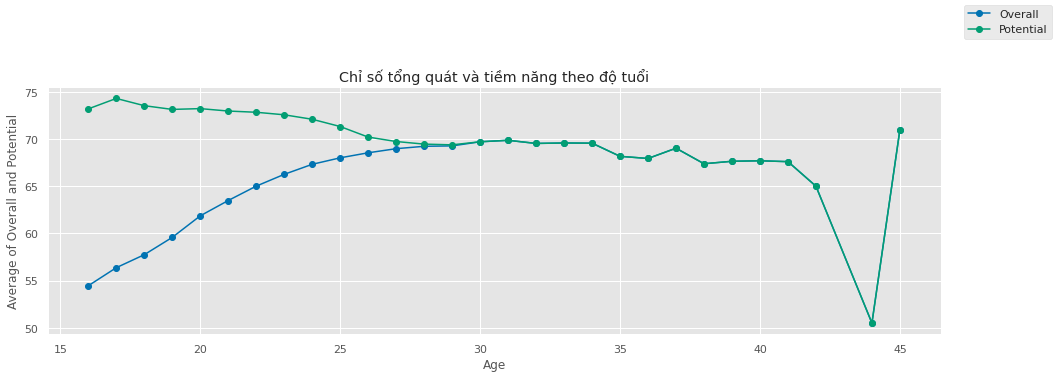

In [272]:
# Vẽ 2 biểu đồ đường trong cùng một biểu đồ
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(211)
linechart = ax.plot(age_value_df.Age, age_value_df.Overall, color='b', marker='o', label='Overall')
linechart2 = ax.plot(age_value_df.Age, age_value_df.Potential, color='g', marker='o', label='Potential')

ax.set_xlabel("Age")
ax.set_ylabel("Average of Overall and Potential")
ax.set_title('Chỉ số tổng quát và tiềm năng theo độ tuổi')
fig.legend()
plt.show()

Dựa vào biểu đồ về Chỉ số tổng quát và tiềm năng theo độ tuổi ở phía trên, ta có thể thấy những cầu thủ dưới 25 tuổi là những cầu thủ trẻ có tiềm năng phát triển rất lớn và cao hơn những cầu thủ "lão tướng", còn những cầu thủ lớn hơn 25 tuổi thì chỉ số tổng quát và tiềm năng bằng nhau, tức là các cầu thủ này đã đạt đỉnh phong độ, không thể lên nữa.

Vậy những cầu thủ trẻ liệu có Giá trị và lương cao hơn những cầu thủ được cho là "lão tướng"?

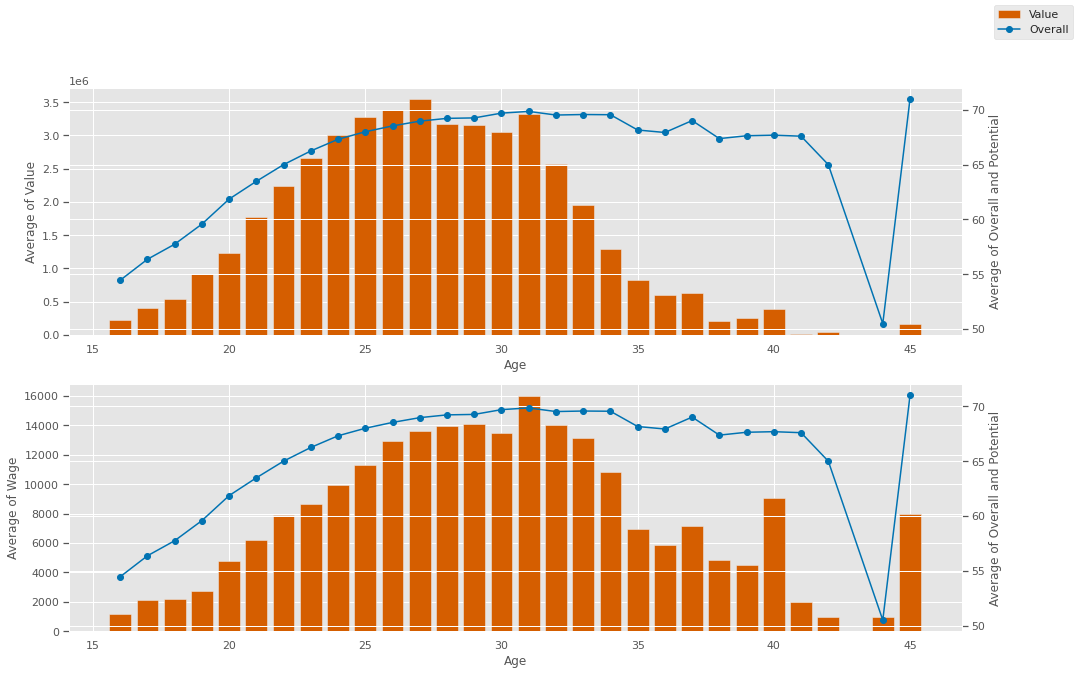

In [273]:
fig = plt.figure(figsize=(16, 10))

# Vẽ biểu đồ về trung bình giá trị theo tuổi
ax = fig.add_subplot(211)
barchart = ax.bar(age_value_df.Age, age_value_df.Value, color='r', label='Value') # Vẽ bar chart
ax2 = ax.twinx()      # Kết hợp 2 biểu đồ
linechart = ax2.plot(age_value_df.Age, age_value_df.Overall, color='b', marker='o', label='Overall') #Line chart

ax.set_xlabel("Age")
ax.set_ylabel("Average of Value")
ax2.set_ylabel("Average of Overall and Potential")
fig.legend()


# Vẽ biểu đồ về trung bình lương theo tuổi
ax = fig.add_subplot(212)
barchart = ax.bar(age_value_df.Age, age_value_df.Wage, color='r', label='Wage') # Vẽ bar chart
ax2 = ax.twinx()   # Kết hợp 2 biểu đồ
linechart = ax2.plot(age_value_df.Age, age_value_df.Overall, color='b', marker='o', label='Overall') #Vẽ line chart

ax.set_xlabel("Age")
ax.set_ylabel("Average of Wage")
ax2.set_ylabel("Average of Overall and Potential")
plt.show()

Độ tuổi có giá trị và lương cao nhất là khoảng từ 25 cho tới 31, đây là độ tuổi các cầu thủ đều đang đạt đỉnh phong độ của mình.

Càng già tuổi (trên 35 tuổi), cầu thủ nhận lương và có giá trị càng thấp mặc dù chỉ số tổng quát của các cầu thủ này cũng đang rất tốt. Điều này có thể phụ thuộc vào nhiều yếu tố như ít nổi tiếng, sức lực giảm,...

Vậy trong số cầu thủ trẻ đầy tiềm năng, ai là người hiện đang có giá trị cao nhất?

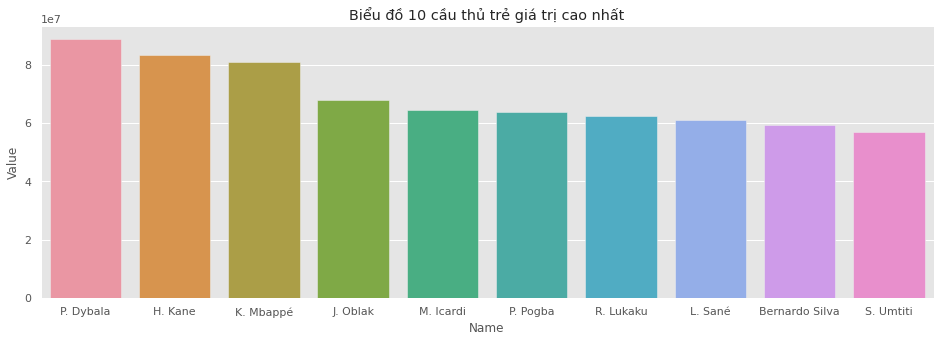

In [300]:
# Lọc ra danh sách cầu thủ dưới 25 tuổi
valuest_young_player = football_df[football_df.Age <= 25][['Name', 'Age', 'Value']] \
                            .sort_values(['Value', 'Age'], ascending=False)

# Lấy 10 cầu thủ cao nhất
top_valuest_player = valuest_young_player.head(10)
plt.figure(figsize=(16, 5))
sns.barplot(x='Name', y="Value", data=top_valuest_player)
plt.title("Biểu đồ 10 cầu thủ trẻ giá trị cao nhất")
plt.show()

Vậy cầu thủ trẻ dưới 25 tuổi có giá trị cao nhất là P.Dybala, thứ hai là H.Kane và thứ 3 là K.Mbappé

Danh sách những cầu thủ đang đạt phong độ và có giá trị cao nhất

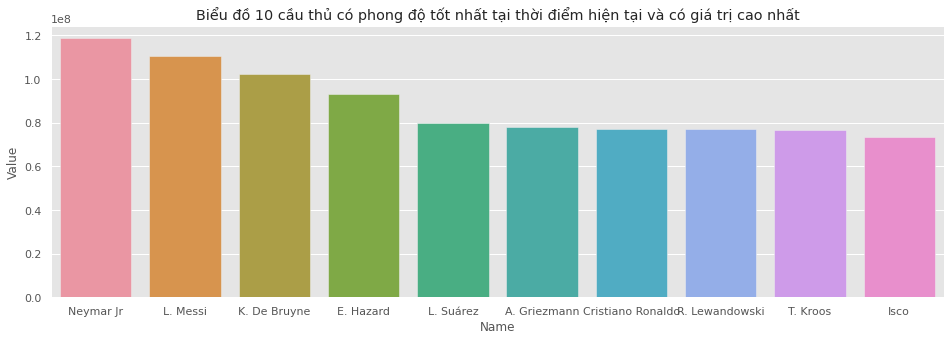

In [303]:
# Lọc ra danh sách cầu thủ trên 25 tuổi
valuest_well_player = football_df[football_df.Age > 25][['Name', 'Age', 'Value']] \
                            .sort_values(['Value', 'Age'], ascending=False)

# Lấy 10 cầu thủ cao nhất
top_valuest_well_player = valuest_well_player.head(10)
plt.figure(figsize=(16, 5))
sns.barplot(x='Name', y="Value", data=top_valuest_well_player)
plt.title("Biểu đồ 10 cầu thủ có phong độ tốt nhất tại thời điểm hiện tại và có giá trị cao nhất")
plt.show()

Cầu thủ hiện đang thi đấu tốt và có giá trị cao nhất ở thời điểm hiện tại là Neymar JR, L.Messi và K. De Bruyne

#### Câu hỏi: Các câu lạc bộ có giá trị cao nhất?

#### Câu hỏi: Quốc gia nào có chất lượng cầu thủ tốt nhất?

Trong bộ dữ liệu có sự góp mặt của các cầu thủ tới từ 164 quốc gia, vậy liệu quốc gia nào sẽ có chất lượng cầu thủ tốt nhất, quốc gia nào sẽ có chỉ số tổng quát (Overall) các cầu thủ đạt cao nhất.

Ta sẽ dùng bản đồ địa lí để minh họa theo giá trị trung bình chỉ số tổng quát.

In [94]:
# Vẽ bản đồ địa lí thể hiện trung bình chỉ số tổng quát Overall của từng quốc gia
nationality_overall_df = football_df.groupby('Nationality')['Overall'].agg('mean').to_frame().reset_index()

fig = px.choropleth(nationality_overall_df, locations='Nationality', 
                    color='Overall', locationmode='country names')

fig.update_layout(title_text='Bản đồ thể hiện trung bình chỉ số tổng quát')
fig.show()

Như ở trên, Châu Âu và khu vực Nam Mỹ có trung bình cầu thủ chất lượng, và Ả Rập Xê-Út là quốc gia có chỉ số cao nhất, lên tới 77 điểm.

## Tham khảo

1. https://plotly.com/python/choropleth-maps